## Foundations of Data Science | 4022 | Dr. Bahrak & Dr. Yaghoobzadeh
## Project Phase02
***
### Amirreza Akbari | 810899045
### Reza Baghestani | 810899046
### Hananeh Jamali | 810899053
***
### 1402/03/27

# Install & Import Libraries

In [467]:
import importlib.util

required_libraries = ["numpy", "pandas", "matplotlib", "seaborn", "scikit-learn"]

for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        # Install the library
        !pip install {lib}

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Part 1: Preprocessing

### Load Scraped Data

In [468]:
# Load the CSV file that contains the scraped data
file_path = 'FinalOutput.csv'
data = pd.read_csv(file_path)


### Handle Missing Values

In [469]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# Handle missing values
data.fillna(np.nan, inplace=True)


Missing Values:
 channel_id                   126
channel_link                 126
channel_name                  47
channel_type                 753
country                       47
country_rank                  47
created_date                  47
daily_subs_average            47
daily_views_average           47
estimated_monthly_income      47
people_rank                   47
social_blade_rank             47
socialblade_url                0
subscriber_rank               47
subscribers                   47
subscribers_last_30_days      47
uploads                       47
video_view_rank               47
views                         47
views_last_30_days            47
yearly_income                 47
Unnamed: 21                 2343
dtype: int64


### Clean Income Values

In [470]:
# Function to clean income data and convert to numerical values
def clean_income(income_str):
    if income_str == 'N/A' or pd.isna(income_str):
        return np.nan
    income_str = str(income_str).replace('€', '').replace('$', '').replace('K', 'e3').replace('M', 'e6').replace('B', 'e9').replace(' ', '').replace(',', '')
    try:
        # Handle ranges by taking the average
        if '-' in income_str:
            low, high = income_str.split('-')
            return (float(eval(low.strip())) + float(eval(high.strip()))) / 2
        else:
            return float(eval(income_str))
    except:
        return np.nan

# Clean and convert 'estimated_monthly_income' and 'yearly_income'
data['estimated_monthly_income'] = data['estimated_monthly_income'].apply(clean_income)
data['yearly_income'] = data['yearly_income'].apply(clean_income)


### Clean Numerical Values

In [471]:
# Convert 'subscribers', 'views_last_30_days', and 'daily_subs_average' to numeric values
def clean_numeric(value):
    if value == 'N/A' or pd.isna(value):
        return np.nan
    value = str(value).replace('K', 'e3').replace('M', 'e6').replace('B', 'e9').replace(',', '').replace('+', '')
    try:
        return float(eval(value))
    except:
        return np.nan

data['subscribers'] = data['subscribers'].apply(clean_numeric)
data['subscribers_last_30_days'] = data['subscribers_last_30_days'].apply(clean_numeric)
data['views_last_30_days'] = data['views_last_30_days'].apply(clean_numeric)
data['daily_subs_average'] = data['daily_subs_average'].apply(clean_numeric)
data['daily_views_average'] = data['daily_views_average'].apply(clean_numeric)

# Convert 'uploads' and 'views' to numeric types if necessary
data['uploads'] = pd.to_numeric(data['uploads'], errors='coerce')
data['views'] = pd.to_numeric(data['views'], errors='coerce')


### Clean Rank Values

In [472]:
# Define a function to preprocess rank values
def preprocess_rank(rank):
    try:
        # Remove commas and non-numeric characters, then convert to float
        rank = float(''.join(filter(str.isdigit, str(rank))))
        return rank
    except:
        return float('nan')  # If conversion fails, return NaN

# Apply the preprocessing function to rank columns
rank_columns = ['video_view_rank', 'social_blade_rank', 'people_rank', 'country_rank', 'subscriber_rank']
for column in rank_columns:
    data[column] = data[column].apply(preprocess_rank)


### Extract Channel Age from Created Date

In [473]:
def calculate_channel_age(created_date):
    if created_date == 'N/A' or pd.isna(created_date):
        return np.nan
    try:
        created_date = datetime.strptime(created_date, '%b %dth, %Y')
        age = (datetime.now() - created_date).days / 365
        return age
    except:
        return np.nan

data['channel_age'] = data['created_date'].apply(calculate_channel_age)

data.drop(columns=['created_date'], inplace=True)


### Save Cleaned Data

In [474]:
data.drop(columns=['Unnamed: 21'], inplace=True)

# Save the cleaned data to a new CSV file
cleaned_file_path = 'cleaned_output.csv'
data.to_csv(cleaned_file_path, index=False)


## EDA

### Load Cleaned Data

In [475]:
# Load the cleaned dataset
file_path = 'cleaned_output.csv'
data_cleaned = pd.read_csv(file_path)


### Correlation Analysis

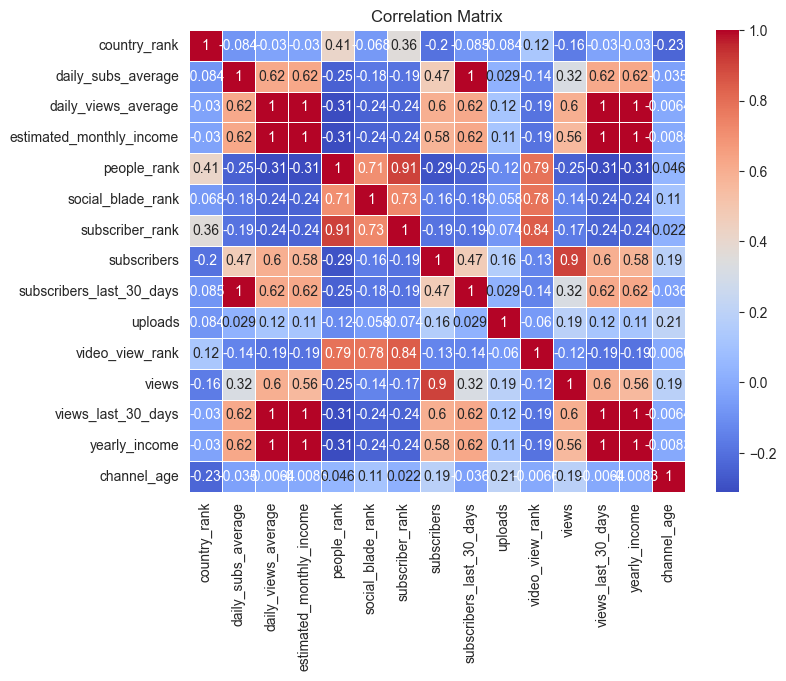

In [476]:
# Select only numerical columns for correlation analysis
numerical_data = data_cleaned.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


### Country-wise Analysis

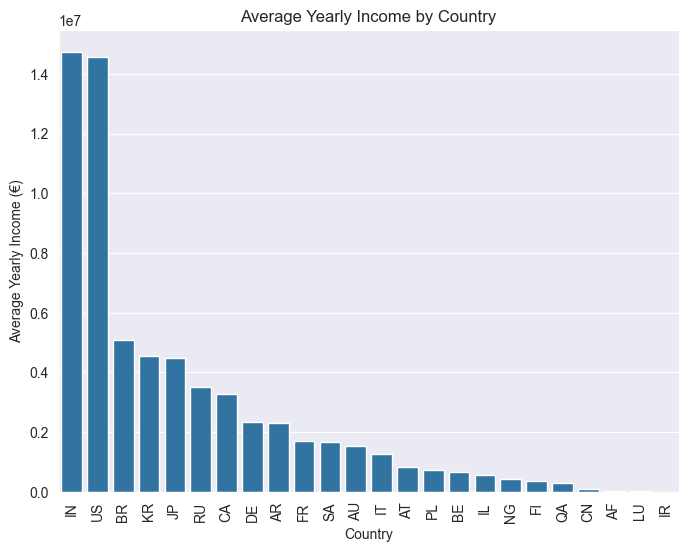

In [477]:
# Plot the average yearly income by country
plt.figure(figsize=(8, 6))
avg_yearly_income_by_country = data_cleaned.groupby('country')['yearly_income'].mean().sort_values(ascending=False)
sns.barplot(x=avg_yearly_income_by_country.index, y=avg_yearly_income_by_country.values)
plt.title('Average Yearly Income by Country')
plt.xlabel('Country')
plt.ylabel('Average Yearly Income (€)')
plt.xticks(rotation=90)
plt.show()


### Countries Distribution

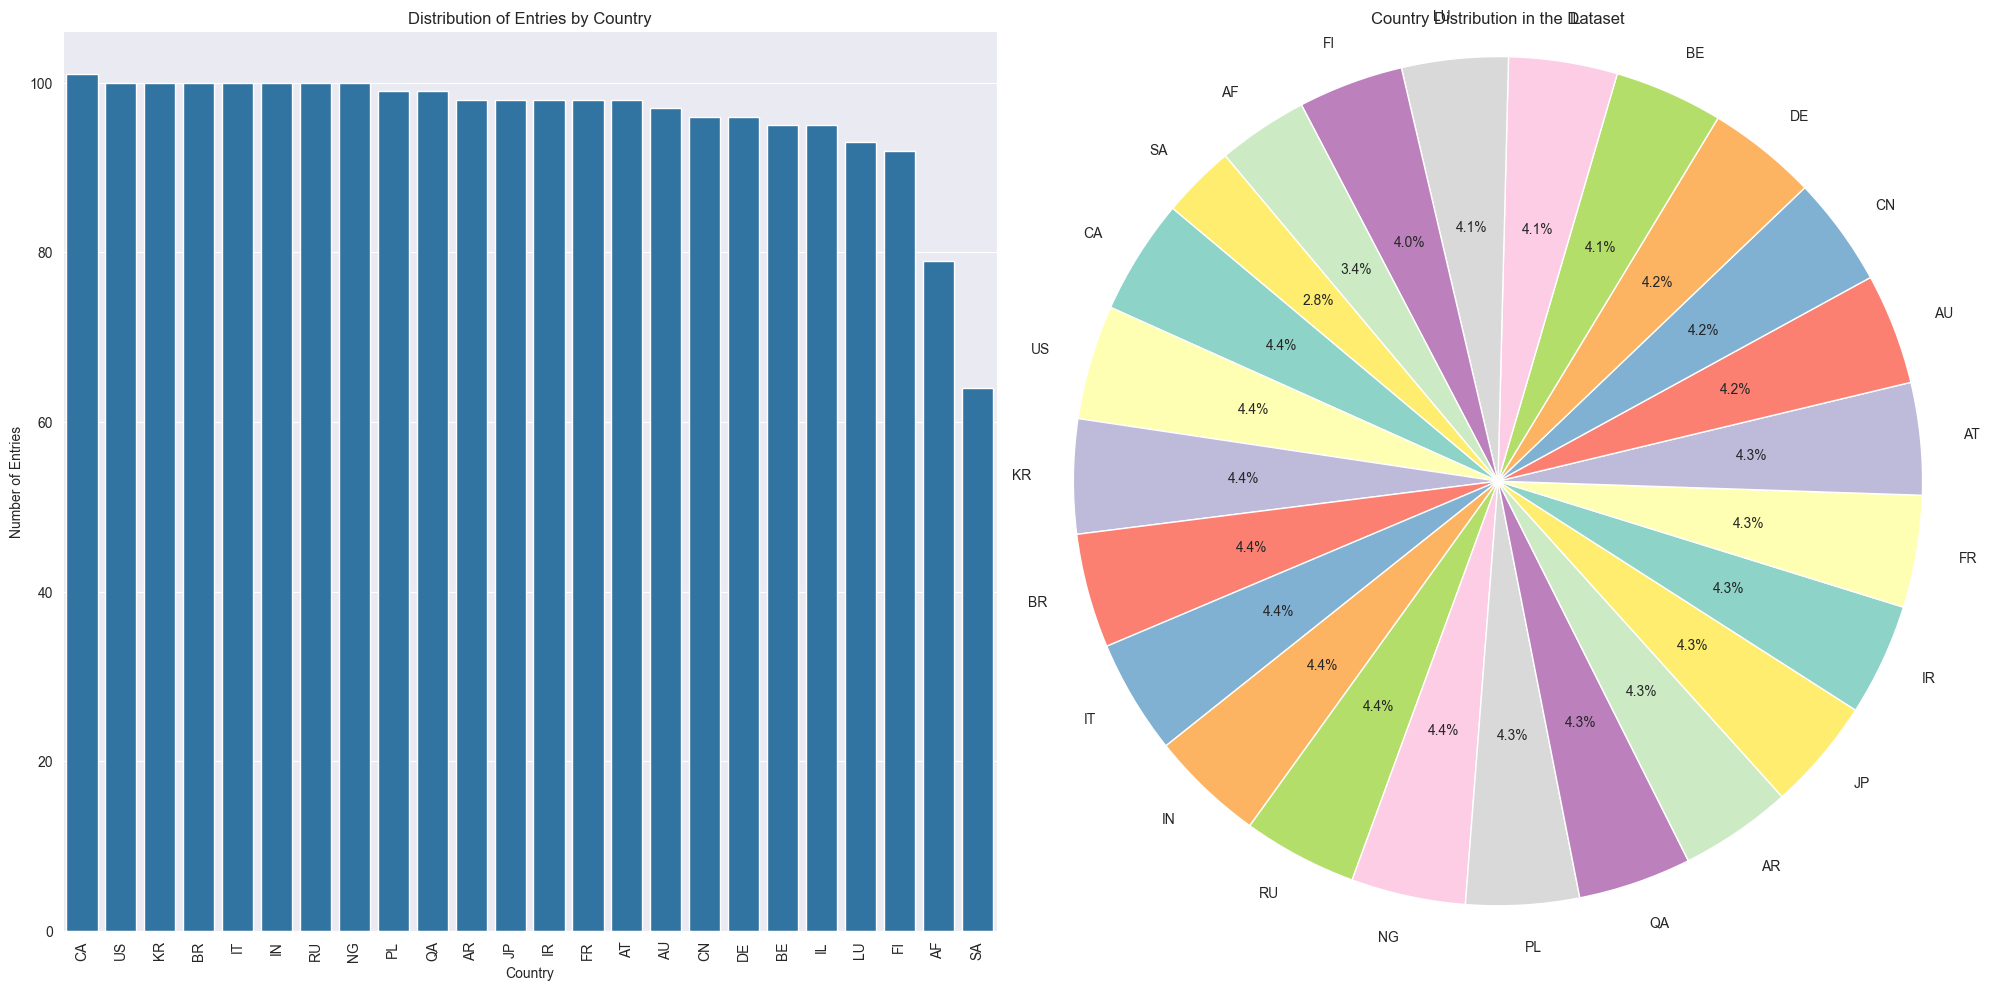

In [478]:
# Count the number of entries per country
country_counts = data_cleaned['country'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the country distribution
sns.barplot(x=country_counts.index, y=country_counts.values, ax=axes[0])
axes[0].set_title('Distribution of Entries by Country')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Number of Entries')
axes[0].tick_params(axis='x', rotation=90)


# Display the country distribution as a pie chart
axes[1].pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
axes[1].set_title('Country Distribution in the Dataset')
axes[1].axis('equal')

plt.tight_layout()
plt.show()


### Distribution of Channels by Channel Type

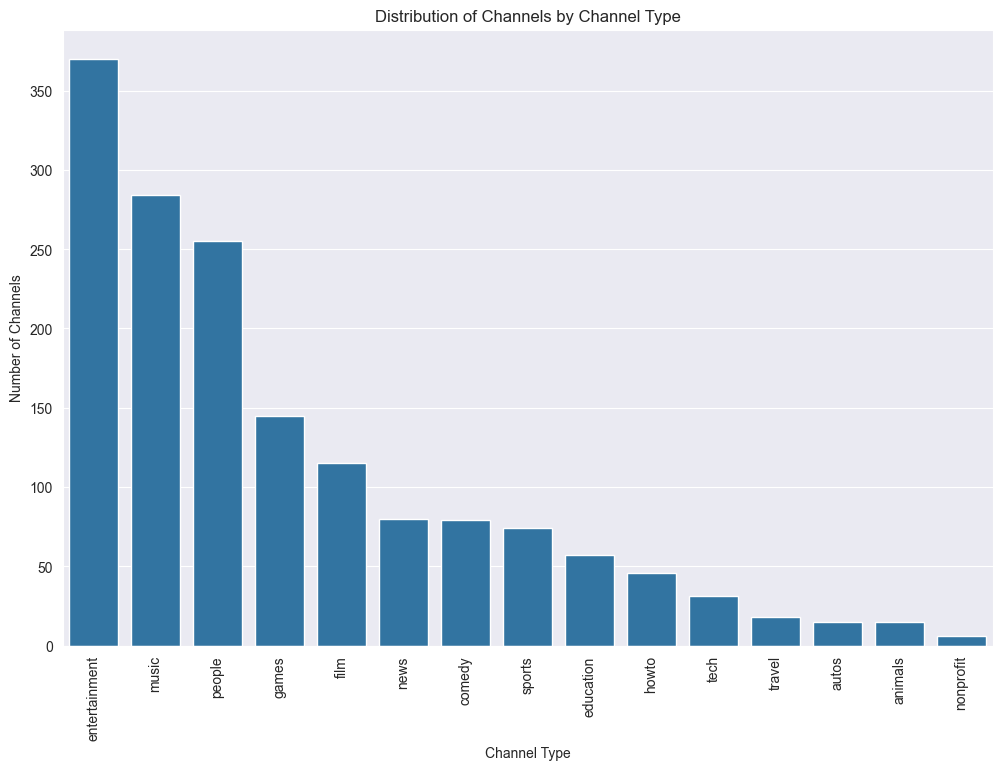

In [479]:
channel_type_counts = data_cleaned['channel_type'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=channel_type_counts.index, y=channel_type_counts.values)
plt.title('Distribution of Channels by Channel Type')
plt.xlabel('Channel Type')
plt.ylabel('Number of Channels')
plt.xticks(rotation=90)
plt.show()


### Incomes of Different Channel Types

<Figure size 1200x800 with 0 Axes>

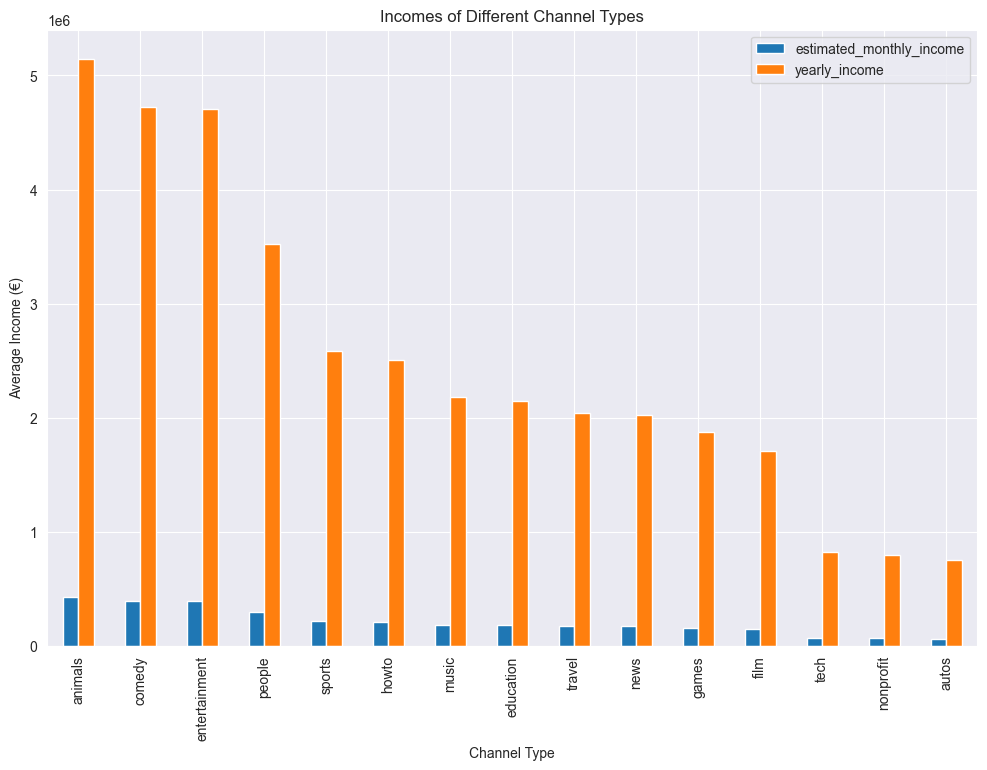

In [480]:
channel_type_incomes = data_cleaned.groupby('channel_type').agg({
    'estimated_monthly_income': 'mean',
    'yearly_income': 'mean'
}).sort_values(by='yearly_income', ascending=False)

plt.figure(figsize=(12, 8))
channel_type_incomes.plot(kind='bar', figsize=(12, 8))
plt.title('Incomes of Different Channel Types')
plt.xlabel('Channel Type')
plt.ylabel('Average Income (€)')
plt.xticks(rotation=90)
plt.show()


### Age Analysis

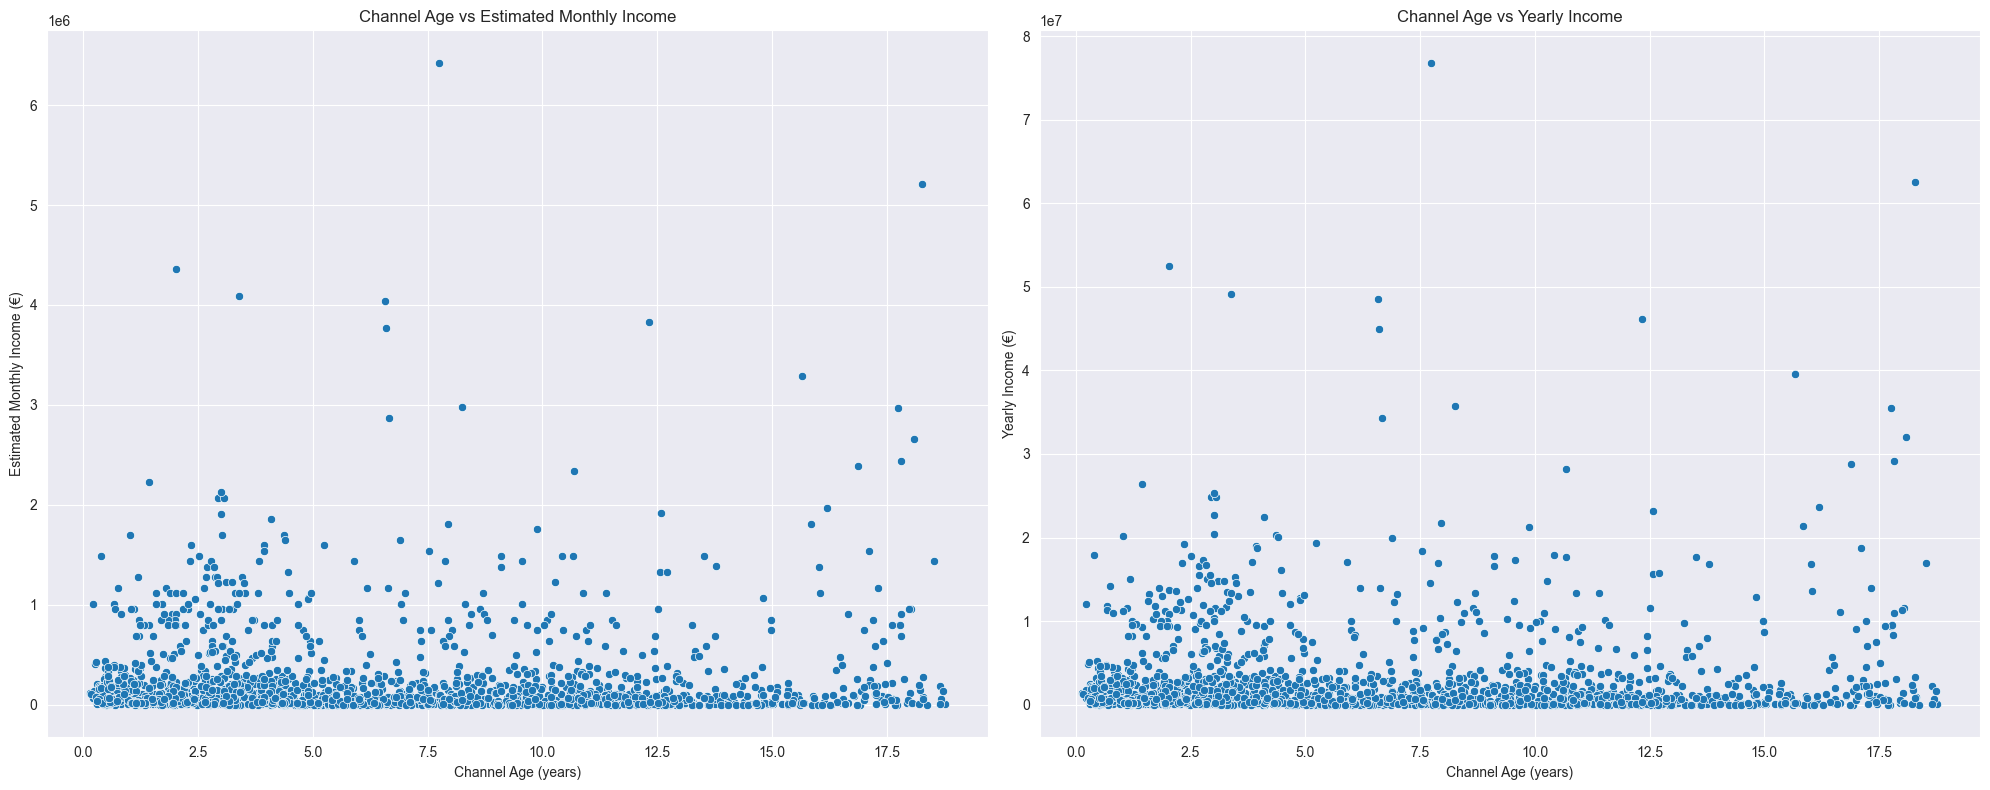

In [481]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Relationship between the age of the channel and its income
sns.scatterplot(x='channel_age', y='estimated_monthly_income', data=data_cleaned, ax=axes[0])
axes[0].set_title('Channel Age vs Estimated Monthly Income')
axes[0].set_xlabel('Channel Age (years)')
axes[0].set_ylabel('Estimated Monthly Income (€)')

sns.scatterplot(x='channel_age', y='yearly_income', data=data_cleaned, ax=axes[1])
axes[1].set_title('Channel Age vs Yearly Income')
axes[1].set_xlabel('Channel Age (years)')
axes[1].set_ylabel('Yearly Income (€)')

plt.tight_layout()
plt.show()


### Normalize Numerical Features

In [482]:
# Initialize the scaler
scaler = StandardScaler()

# Select numerical features for scaling
numerical_features = ['views', 'subscribers', 'uploads', 'daily_subs_average', 'daily_views_average', 'estimated_monthly_income', 'views_last_30_days', 'yearly_income', 'channel_age']

# Apply scaling
data_cleaned[numerical_features] = scaler.fit_transform(data_cleaned[numerical_features])


### Drop Unnecessary Columns

In [483]:
columns_to_drop = ['channel_id', 'channel_link', 'socialblade_url']
data_cleaned.drop(columns=columns_to_drop, inplace=True)


### Encode Categorical Features

In [484]:
# Use one-hot encoding for 'channel_type' and 'country'
encoded_data = pd.get_dummies(data_cleaned, columns=['channel_type', 'country'], drop_first=True)


### Final Check and Summary

In [485]:
# Check the final cleaned and preprocessed data
print(encoded_data.info())
print(encoded_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   channel_name                2296 non-null   object 
 1   country_rank                2295 non-null   float64
 2   daily_subs_average          2194 non-null   float64
 3   daily_views_average         2288 non-null   float64
 4   estimated_monthly_income    2296 non-null   float64
 5   people_rank                 1589 non-null   float64
 6   social_blade_rank           2296 non-null   float64
 7   subscriber_rank             2296 non-null   float64
 8   subscribers                 2296 non-null   float64
 9   subscribers_last_30_days    2197 non-null   float64
 10  uploads                     2296 non-null   float64
 11  video_view_rank             2296 non-null   float64
 12  views                       2296 non-null   float64
 13  views_last_30_days          2288 

## Save Final Clean Data

In [486]:
# Save the final clean data to a new CSV file
final_clean_file_path = 'final_clean_output.csv'
data_cleaned.to_csv(final_clean_file_path, index=False)


# Part 2: Feature Engineering and Selection

In [487]:
# Load the final clean dataset
file_path = 'final_clean_output.csv'
data_cleaned = pd.read_csv(file_path)

# 1. Interaction feature: daily_subs_average * daily_views_average
data_cleaned['subs_views_interaction'] = data_cleaned['daily_subs_average'] * data_cleaned['daily_views_average']

# 2. Ratio feature: subscribers / uploads
data_cleaned['subs_per_upload'] = data_cleaned['subscribers'] / data_cleaned['uploads']

# 3. Log transformation of views_last_30_days (handling potential skewness)
data_cleaned['log_views_last_30_days'] = np.log1p(data_cleaned['views_last_30_days'])

# 4. Mean estimated_monthly_income per channel_type
mean_income_per_type = data_cleaned.groupby('channel_type')['estimated_monthly_income'].transform('mean')
data_cleaned['mean_income_per_type'] = mean_income_per_type

# 5. Length of channel_name
data_cleaned['channel_name_length'] = data_cleaned['channel_name'].str.len()

# Display the updated dataframe information
print(data_cleaned.info())

# Save the updated dataset to a new CSV file
data_cleaned.to_csv('feature_engineered_data.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   channel_name              2296 non-null   object 
 1   channel_type              1590 non-null   object 
 2   country                   2296 non-null   object 
 3   country_rank              2295 non-null   float64
 4   daily_subs_average        2194 non-null   float64
 5   daily_views_average       2288 non-null   float64
 6   estimated_monthly_income  2296 non-null   float64
 7   people_rank               1589 non-null   float64
 8   social_blade_rank         2296 non-null   float64
 9   subscriber_rank           2296 non-null   float64
 10  subscribers               2296 non-null   float64
 11  subscribers_last_30_days  2197 non-null   float64
 12  uploads                   2296 non-null   float64
 13  video_view_rank           2296 non-null   float64
 14  views   

C:\Users\Amirreza\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Part 3: Dimensionality Reduction

In [488]:
# Select numerical features for PCA
numerical_features = [
    'daily_subs_average',
    'daily_views_average',
    'estimated_monthly_income',
    'subscribers',
    'uploads',
    'views_last_30_days',
    'channel_age',
    'subs_views_interaction',
    'subs_per_upload',
    'log_views_last_30_days',
    'mean_income_per_type',
    'channel_name_length'
]

# Subset the data with numerical features
numerical_data = data_cleaned[numerical_features]

# Impute missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
numerical_data_imputed = imputer.fit_transform(numerical_data)

# Standardize the numerical data
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data_imputed)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep components that explain 95% of the variance
pca_result = pca.fit_transform(numerical_data_scaled)

# Number of components selected
print(f"Number of components selected by PCA: {pca_result.shape[1]}")

# Update the DataFrame with PCA components
pca_columns = [f"PC{i+1}" for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

# Concatenate PCA components with the original DataFrame
data_cleaned_pca = pd.concat([data_cleaned, pca_df], axis=1)

# Drop original numerical features (optional)
data_cleaned_pca.drop(columns=numerical_features, inplace=True)

# Display the updated DataFrame information
print(data_cleaned_pca.info())


Number of components selected by PCA: 8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   channel_name              2296 non-null   object 
 1   channel_type              1590 non-null   object 
 2   country                   2296 non-null   object 
 3   country_rank              2295 non-null   float64
 4   people_rank               1589 non-null   float64
 5   social_blade_rank         2296 non-null   float64
 6   subscriber_rank           2296 non-null   float64
 7   subscribers_last_30_days  2197 non-null   float64
 8   video_view_rank           2296 non-null   float64
 9   views                     2296 non-null   float64
 10  yearly_income             2296 non-null   float64
 11  PC1                       2343 non-null   float64
 12  PC2                       2343 non-null   float64
 13  PC3                    

# Part 4: Evaluation Metrics (and Handling Non-Numerical Columns)
# Part 5: Model Training

In [489]:
# Handle categorical features
categorical_features = ['channel_type']
data_cleaned_pca = pd.get_dummies(data_cleaned_pca, columns=categorical_features, drop_first=True)

# Define features (X) and target (y)
X = data_cleaned_pca.drop(columns=['yearly_income', 'channel_name', 'country'])
y = data_cleaned_pca['yearly_income']

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Impute missing values in target
y = y.values.reshape(-1, 1)  # Reshape y to be a 2D array
y_imputed = imputer.fit_transform(y).ravel()  # Impute and then flatten back to 1D

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=36)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 0.047601215464094376
Mean Squared Error (MSE): 0.0069671515992217855
Root Mean Squared Error (RMSE): 0.08346946507089754
R-squared (R²): 0.9876765831018884


### Model Comparison

In [490]:
# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

# Initialize models
ridge = Ridge(random_state=36)
lasso = Lasso(random_state=36)
random_forest = RandomForestRegressor(random_state=36)

# Evaluate Ridge Regression
ridge_mae, ridge_mse, ridge_rmse, ridge_r2 = evaluate_model(ridge, X_train, X_test, y_train, y_test)
print(f"Ridge Regression - MAE: {ridge_mae}, MSE: {ridge_mse}, RMSE: {ridge_rmse}, R²: {ridge_r2}")

# Evaluate Lasso Regression
lasso_mae, lasso_mse, lasso_rmse, lasso_r2 = evaluate_model(lasso, X_train, X_test, y_train, y_test)
print(f"Lasso Regression - MAE: {lasso_mae}, MSE: {lasso_mse}, RMSE: {lasso_rmse}, R²: {lasso_r2}")

# Evaluate Random Forest Regressor
rf_mae, rf_mse, rf_rmse, rf_r2 = evaluate_model(random_forest, X_train, X_test, y_train, y_test)
print(f"Random Forest Regressor - MAE: {rf_mae}, MSE: {rf_mse}, RMSE: {rf_rmse}, R²: {rf_r2}")


Ridge Regression - MAE: 0.04748913907146769, MSE: 0.006925788615881743, RMSE: 0.08322132308418163, R²: 0.9877497454668219
Lasso Regression - MAE: 0.29605309531252655, MSE: 0.2332274633514361, RMSE: 0.48293629326385906, R²: 0.5874699693214914
Random Forest Regressor - MAE: 0.030908168501647168, MSE: 0.005289712266525149, RMSE: 0.07273040812841043, R²: 0.9906436183276498


# Part 6: Feature Importance Analysis

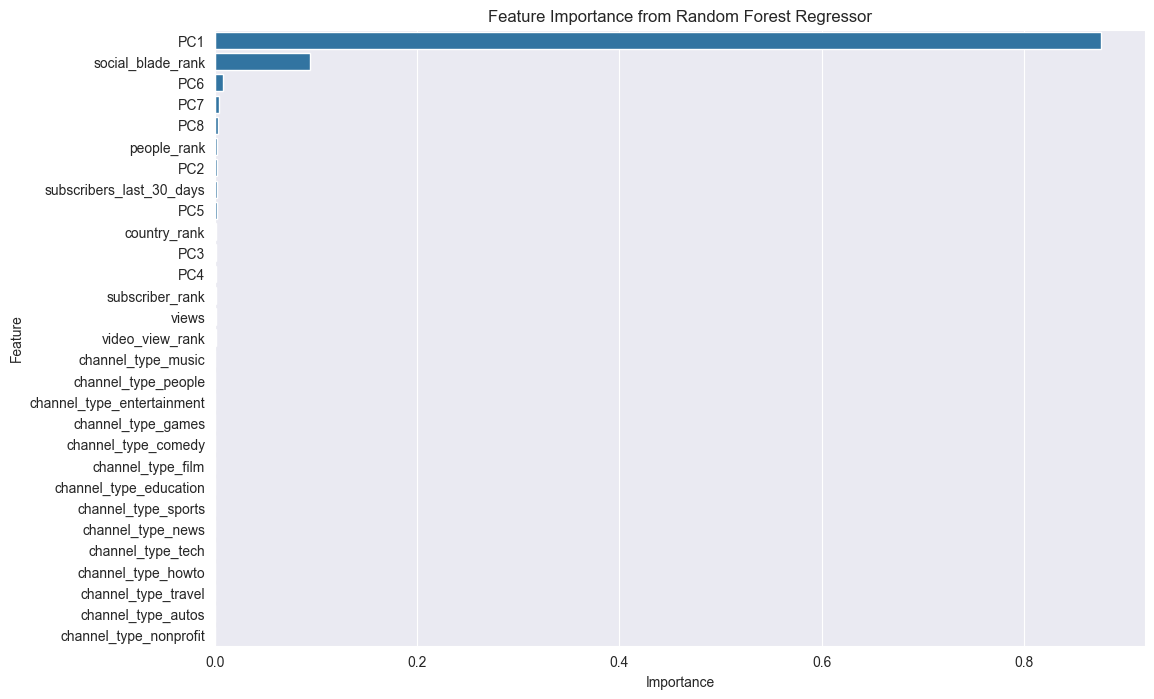

In [491]:
# Get feature importance
feature_importances = random_forest.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest Regressor')
plt.show()


### Cross-Validation

In [492]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(random_forest, X_imputed, y_imputed, cv=5, scoring='r2')

# Print cross-validation results
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of R² Scores: {np.std(cv_scores)}")


Cross-Validation R² Scores: [0.90295764 0.99287795 0.93902733 0.975947   0.97857827]
Mean R² Score: 0.957877637966852
Standard Deviation of R² Scores: 0.03271568592094509


### Hyperparameter Tuning

In [493]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
best_mae = mean_absolute_error(y_test, y_pred_best)
best_mse = mean_squared_error(y_test, y_pred_best)
best_rmse = np.sqrt(best_mse)
best_r2 = r2_score(y_test, y_pred_best)

print(f"Best Model - MAE: {best_mae}, MSE: {best_mse}, RMSE: {best_rmse}, R²: {best_r2}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Model - MAE: 0.03045964747317947, MSE: 0.005236045022563199, RMSE: 0.07236052116011325, R²: 0.990738544325986


# Part 7: Predict New Data

### Preprocess, Apply PCA and Feature Engineering to New Data

In [494]:
# Load the CSV file that contains the new scraped data
file_path = 'NewData7.csv'
new_data = pd.read_csv(file_path)

# Handle missing values
new_data.fillna(np.nan, inplace=True)

# Clean income values
new_data['estimated_monthly_income'] = new_data['estimated_monthly_income'].apply(clean_income)
new_data['yearly_income'] = new_data['yearly_income'].apply(clean_income)

# Clean numerical values
new_data['subscribers'] = new_data['subscribers'].apply(clean_numeric)
new_data['subscribers_last_30_days'] = new_data['subscribers_last_30_days'].apply(clean_numeric)
new_data['views_last_30_days'] = new_data['views_last_30_days'].apply(clean_numeric)
new_data['daily_subs_average'] = new_data['daily_subs_average'].apply(clean_numeric)
new_data['daily_views_average'] = new_data['daily_views_average'].apply(clean_numeric)

# Convert 'uploads' and 'views' to numeric types if necessary
new_data['uploads'] = pd.to_numeric(new_data['uploads'], errors='coerce')
new_data['views'] = pd.to_numeric(new_data['views'], errors='coerce')

# Clean rank values
rank_columns = ['video_view_rank', 'social_blade_rank', 'people_rank', 'country_rank', 'subscriber_rank']
for column in rank_columns:
    new_data[column] = new_data[column].apply(preprocess_rank)

# Extract channel age
new_data['channel_age'] = new_data['created_date'].apply(calculate_channel_age)

new_data.drop(columns=['created_date'], inplace=True)

# Normalize numerical features
# Initialize the scaler
scaler = StandardScaler()

# Select numerical features for scaling
numerical_features = ['views', 'subscribers', 'uploads', 'daily_subs_average', 'daily_views_average', 'estimated_monthly_income', 'views_last_30_days', 'yearly_income', 'channel_age']

# Apply scaling
new_data[numerical_features] = scaler.fit_transform(new_data[numerical_features])

# Drop unnecessary columns
columns_to_drop = ['channel_id', 'channel_link', 'socialblade_url']
new_data.drop(columns=columns_to_drop, inplace=True)

# One-hot encode categorical features
encoded_data = pd.get_dummies(new_data, columns=['channel_type', 'country'], drop_first=True)

# 1. Interaction feature: daily_subs_average * daily_views_average
new_data['subs_views_interaction'] = new_data['daily_subs_average'] * new_data['daily_views_average']

# 2. Ratio feature: subscribers / uploads
new_data['subs_per_upload'] = new_data['subscribers'] / new_data['uploads']

# 3. Log transformation of views_last_30_days (handling potential skewness)
new_data['log_views_last_30_days'] = np.log1p(new_data['views_last_30_days'])

# 4. Mean estimated_monthly_income per channel_type
mean_income_per_type = new_data.groupby('channel_type')['estimated_monthly_income'].transform('mean')
new_data['mean_income_per_type'] = mean_income_per_type

# 5. Length of channel_name
new_data['channel_name_length'] = new_data['channel_name'].str.len()

# Select numerical features for PCA
numerical_features = [
    'daily_subs_average',
    'daily_views_average',
    'estimated_monthly_income',
    'subscribers',
    'uploads',
    'views_last_30_days',
    'channel_age',
    'subs_views_interaction',
    'subs_per_upload',
    'log_views_last_30_days',
    'mean_income_per_type',
    'channel_name_length'
]

# Subset the data with numerical features
numerical_data = new_data[numerical_features]

# Impute missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
numerical_data_imputed = imputer.fit_transform(numerical_data)

# Standardize the numerical data
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data_imputed)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep components that explain 95% of the variance
pca_result = pca.fit_transform(numerical_data_scaled)

# Update the DataFrame with PCA components
pca_columns = [f"PC{i+1}" for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

# Concatenate PCA components with the original DataFrame
new_data_pca = pd.concat([new_data, pca_df], axis=1)

# Drop original numerical features (optional)
new_data_pca.drop(columns=numerical_features, inplace=True)

# Save the final new data to a new CSV file
final_new_file_path = 'NewData7_final.csv'
new_data_pca.to_csv(final_new_file_path, index=False)


C:\Users\Amirreza\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Predict New Clean Data

In [495]:
# Load the CSV file that contains the final new data
file_path = 'NewData7_final.csv'
final_new_data = pd.read_csv(file_path)

# Handle categorical features
categorical_features = ['channel_type']
final_new_data = pd.get_dummies(final_new_data, columns=categorical_features, drop_first=True)

# Define features (X) and target (y)
X = final_new_data.drop(columns=['yearly_income', 'channel_name', 'country'])
y = final_new_data['yearly_income']

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Impute missing values in target
y = y.values.reshape(-1, 1)  # Reshape y to be a 2D array
y_imputed = imputer.fit_transform(y).ravel()  # Impute and then flatten back to 1D

# Make predictions on the target
y_pred = best_model.predict(X_imputed)

# Calculate evaluation metrics
mae = mean_absolute_error(y_imputed, y_pred)
mse = mean_squared_error(y_imputed, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_imputed, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 0.14339210292299603
Mean Squared Error (MSE): 0.1525743831634637
Root Mean Squared Error (RMSE): 0.390607710066588
R-squared (R²): 0.8429182495348091
